# Fault detection

Here we will demonstrate training process of fault detection model

## Content

* [Task](#Task)
* [Dataset](#Dataset)
* [Model architecture](#Architecture)
* [Training](#Training)
* [Inference](#Inference)

## Task

The task is to detect faults on seismic cube. More detailed, to construct binary mask where each pixel is assigned to positive class (fault) or to negative (not fault).

In [1]:
import sys
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

sys.path.append('../..')

from seismiqb import *

from seismiqb.batchflow import FilesIndex, Pipeline, Notifier
from seismiqb.batchflow.research import Option, Research, Results, RP, RC, RD, REP, KV, RI
from seismiqb.batchflow.models.torch import EncoderDecoder, ResBlock, TorchModel
from seismiqb.batchflow import D, B, V, P, R, L, W, C
from seismiqb.batchflow.models.torch.losses.binary import Dice

import warnings
warnings.filterwarnings("ignore")

## Dataset

Train dataset is a set of labeled cubes. Annotation for the model is an interpolated version of sticks. Initially, we have a set of slices of cube where faults are labeled as sticks. We interpolated them and saved as a set of points in cube coordinated.
Train dataset consists of 4 cubes, model will be trained on crops of size (1, 128, 512) from the cube.

Almost all cubes have faults located along ilines, cubes in `TRANSPOSE` list have faults located along crosslines.

In [2]:
CUBES = ['CUBE_01_ETP', 'CUBE_16_PSDM', 'CUBE_23_VYNGAYAHA', 'CUBE_22_VALYNTOY']
TRANSPOSE = ['CUBE_23_VYNGAYAHA']

CROP_SHAPE = np.array((1, 128, 512))
N_ITERS = 5000
BATCH_SIZE = 128
INFERENCE_BATCH_SIZE = 32

def amplitudes_path(cube):
    return glob.glob('/data/seismic_data/seismic_interpretation/' + cube + '/amplitudes*.hdf5')[0]

paths = [amplitudes_path(item) for item in CUBES]
transpose_paths = [os.path.splitext(amplitudes_path(item).split('/')[-1])[0] for item in TRANSPOSE]

dataset = SeismicCubeset(FilesIndex(path=paths, no_ext=True))

dataset.load(label_dir='/INPUTS/FAULTS/NPY_WIDTH_3/*', labels_class=Fault, transform=True, verify=True)
dataset.modify_sampler(dst='train_sampler', finish=True, low=0.0, high=1.0)

Let's plot 2D maps of faults for each cube and examples of slices.

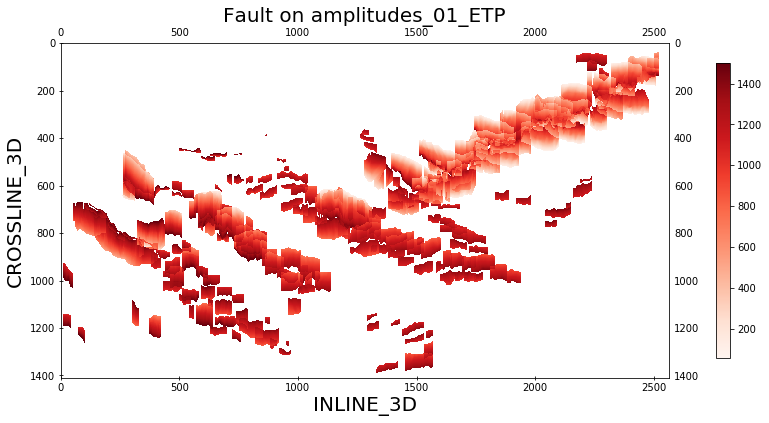

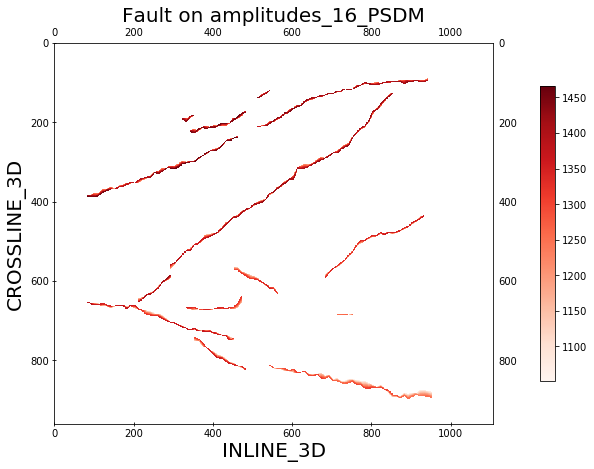

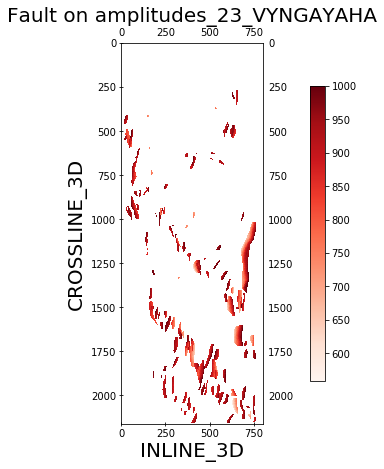

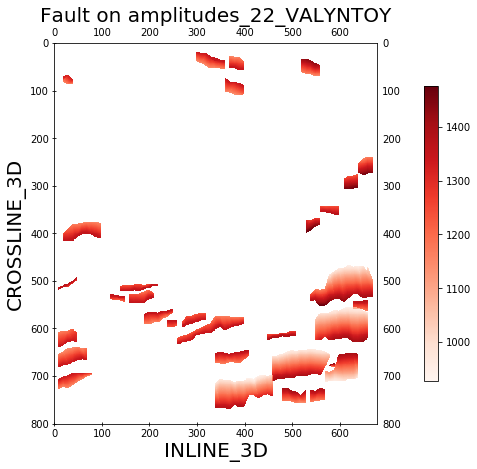

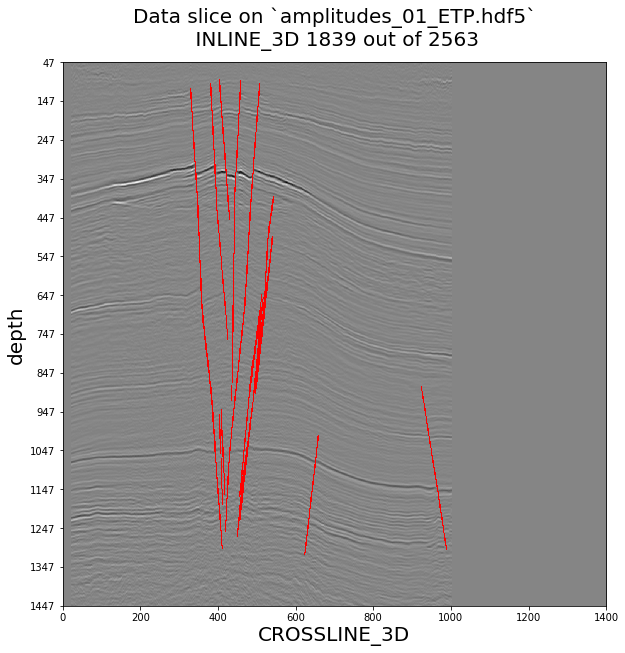

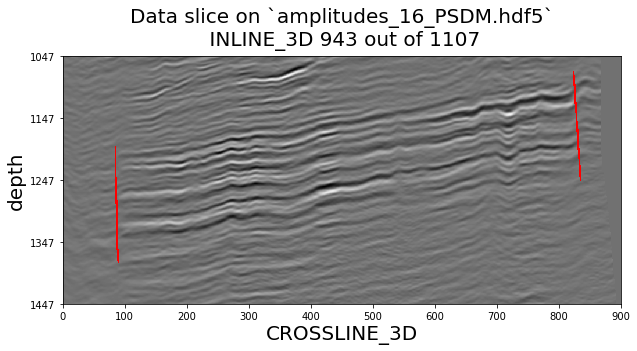

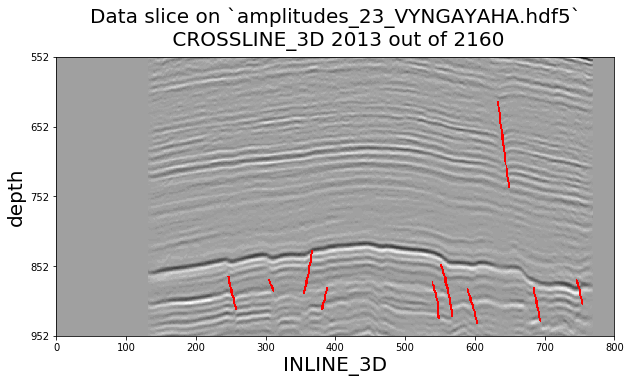

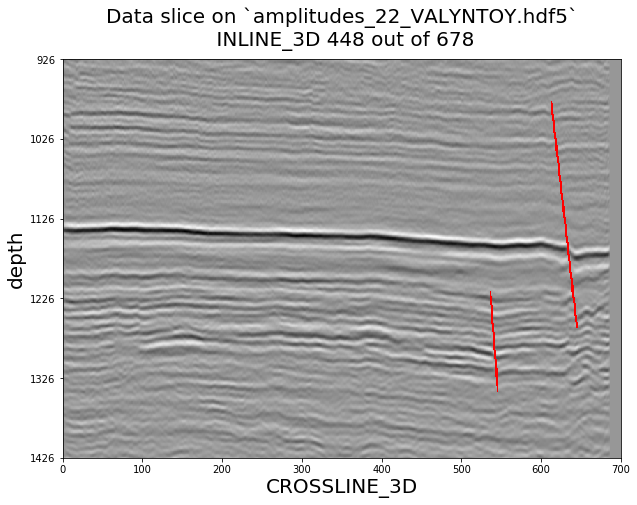

In [3]:
ratios = {}

for i in range(len(dataset)):
    fault_volume = sum([len(np.unique(fault.points)) for fault in dataset.labels[i]])
    cube_volume = np.prod(dataset.geometries[i].cube_shape)
    dataset.show_points(idx=i)
    ratios[dataset.indices[i]] = fault_volume / cube_volume

for i in range(len(dataset)):
    bounds = min([fault.points[:, 2].min() for fault in dataset.labels[i]]), max([fault.points[:, 2].max() for fault in dataset.labels[i]])
    axis = 1 if dataset.indices[i] in transpose_paths else 0
    dataset.show_slide(dataset.labels[i][0].points[0, axis], idx=i, axis=axis,
                       figsize=(10, 10), zoom_slice = (slice(None, None), slice(*bounds)))

Cubes have different sizes of faults and their quantity. To normalize sampling we compute weights for each cube.

In [4]:
weights = np.array([ratios[i] for i in dataset.indices]) / sum(ratios.values())
weights = weights.clip(min=0.05, max=0.5)
weights = weights / weights.sum()

dataset.create_sampler(p=list(weights))
dataset.modify_sampler(dst='train_sampler', finish=True, low=0.0, high=1.0)

In [5]:
for cube, weight in zip(dataset.indices, weights):
    print(f'{cube}: {weight:4.3f}')

amplitudes_01_ETP: 0.505
amplitudes_16_PSDM: 0.051
amplitudes_23_VYNGAYAHA: 0.237
amplitudes_22_VALYNTOY: 0.207


## Architecture

To train the model we use U-Net-like architecture.

Model was trained on crops of size (1, 128, 512). Loss for the model is element-wise Dice.

In [6]:
FILTERS = [64, 96, 128, 192, 256]

MODEL_CONFIG = {
    # Model layout
    'initial_block': {
        'base_block': ResBlock,
        'filters': FILTERS[0] // 2,
        'kernel_size': 5,
        'downsample': False,
        'attention': 'scse'
    },

    'body/encoder': {
        'num_stages': 4,
        'order': 'sbd',
        'blocks': {
            'base': ResBlock,
            'n_reps': 1,
            'filters': FILTERS[:-1],
            'attention': 'scse',
        },
    },
    'body/embedding': {
        'base': ResBlock,
        'n_reps': 1,
        'filters': FILTERS[-1],
        'attention': 'scse',
    },
    'body/decoder': {
        'num_stages': 4,
        'upsample': {
            'layout': 'tna',
            'kernel_size': 5,
        },
        'blocks': {
            'base': ResBlock,
            'filters': FILTERS[-2::-1],
            'attention': 'scse',
        },
    },
    'head': {
        'base_block': ResBlock,
        'filters': [16, 8],
        'attention': 'scse'
    },
    'output': torch.sigmoid,
    # Train configuration
    'loss': Dice(),
    'optimizer': {'name': 'Adam', 'lr': 0.01,},
    # "decay": {'name': 'exp', 'gamma': 0.1, 'frequency': 150},
    'microbatch': 8,
    'common/activation': 'relu6',
}

In [7]:
shape = {item: CROP_SHAPE[[1, 0, 2]] if item in transpose_paths else CROP_SHAPE for item in dataset.indices}

load_template = (
    Pipeline()
    # Initialize pipeline variables and model
    .init_variable('loss_history', [])
    .init_model('dynamic', EncoderDecoder, 'model', MODEL_CONFIG)

    # Load data/masks
    .crop(points=D('train_sampler')(BATCH_SIZE), shape=shape, side_view=False)
    .create_masks(dst='masks')
    #.mask_rebatch(src='masks', threshold=0.5, axis=(0, 1))
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images', 'masks'], shape=CROP_SHAPE)
    .scale(mode='q', src='images')
    .run_later(D('size'), n_iters=N_ITERS, prefetch=4)
)

augmentation_template = (
    Pipeline()
    # Augmentations
    .transpose(src=['images', 'masks'], order=(1, 2, 0))
    .flip(axis=1, src=['images', 'masks'], seed=P(R('uniform', 0, 1)), p=0.3)
    .additive_noise(scale=0.005, src='images', dst='images', p=0.3)
    .rotate(angle=P(R('uniform', -15, 15)),
            src=['images', 'masks'], p=0.3)
    .scale_2d(scale=P(R('uniform', 0.85, 1.15)),
              src=['images', 'masks'], p=0.3)
    .cutout_2d(src=['images'], patch_shape=np.array((40, 40)), n=4, p=0.3)
    .transpose(src=['images', 'masks'], order=(2, 0, 1))
    # Training
)

model_template = (
    Pipeline()
    .train_model('model',
                 fetches='loss',
                 images=B('images'),
                 masks=B('masks'),
                 save_to=V('loss_history', mode='a'))
)

Let's see examples of augmented crops

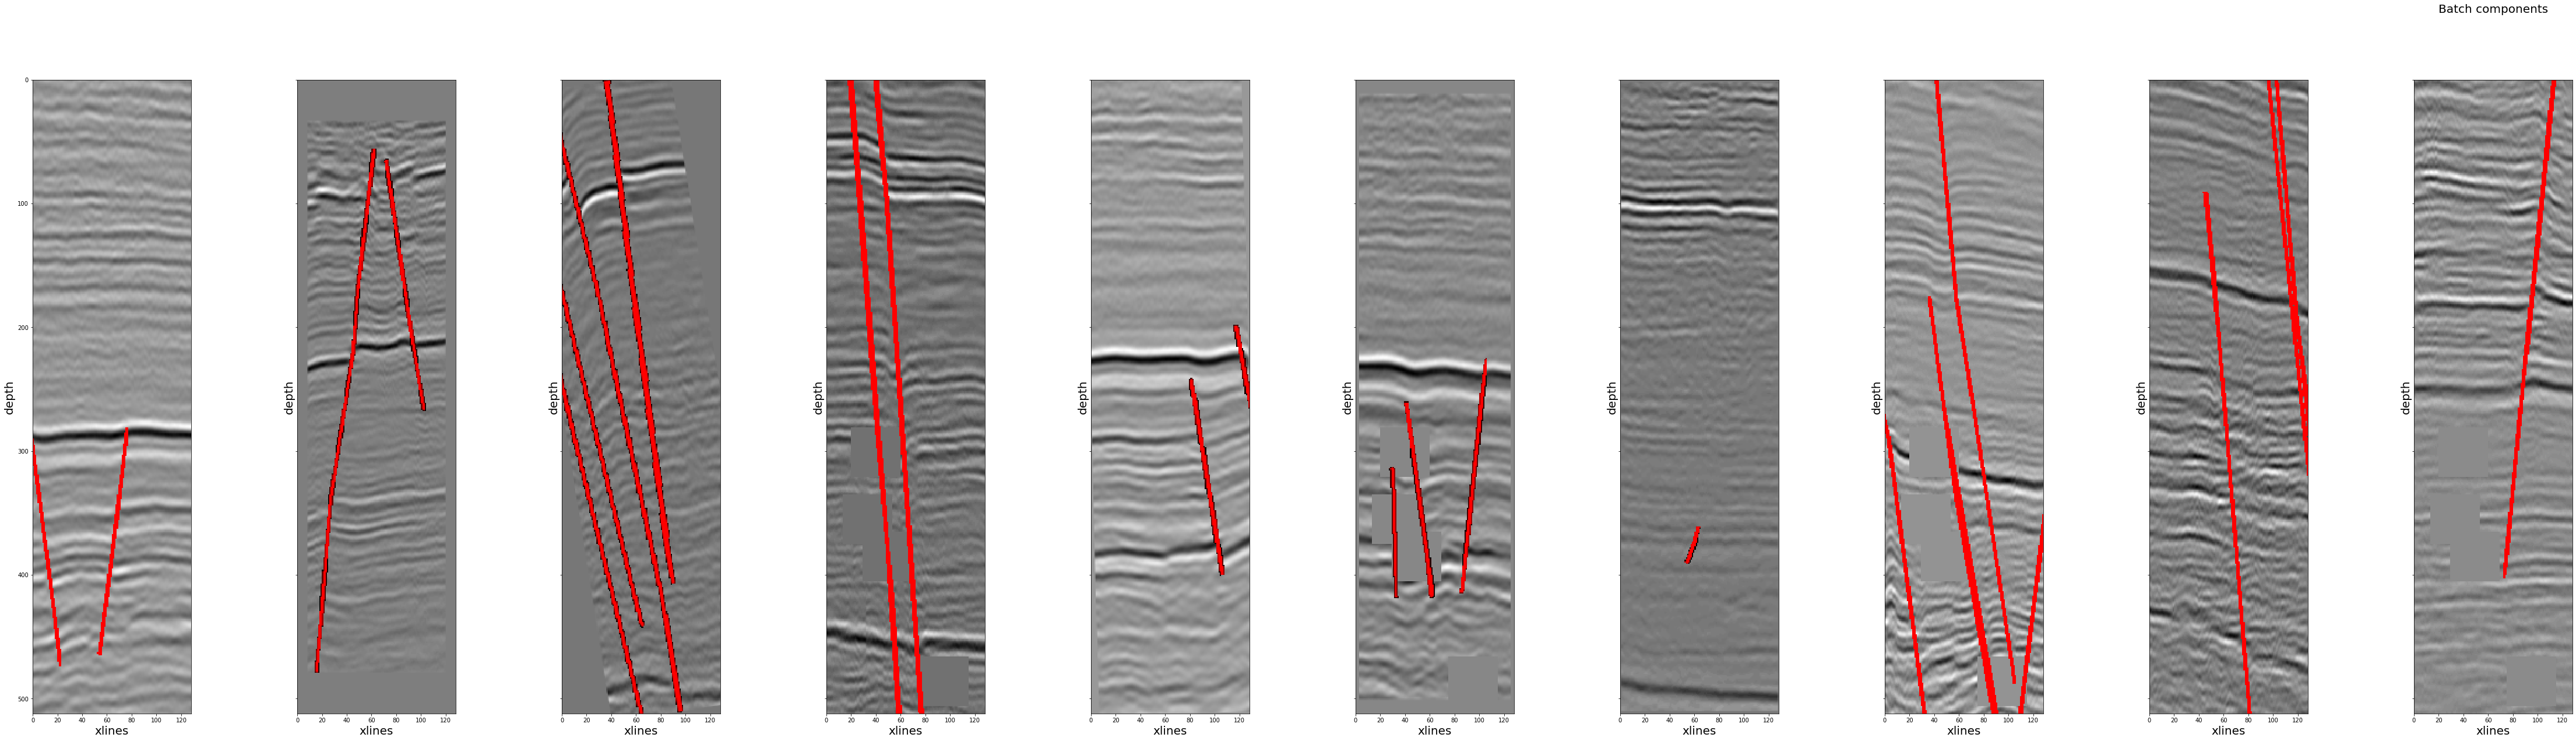

In [8]:
pipeline = load_template + augmentation_template << dataset
batch = pipeline.next_batch()

f, ax = plt.subplots(1, 10, sharey=True, figsize=(80, 20))
for b_idx in range(10):
    batch.plot_components('images', 'masks', slide=0, mode='overlap', idx=b_idx, alpha=[0.9, 0.5], ax=ax[b_idx])

And now let's start training

In [9]:
train_pipeline = load_template + augmentation_template + model_template << dataset
train_pipeline.run()

In [10]:
train_pipeline.save_model_now('model', 'model.torch')
np.save('loss.npy', train_pipeline.v('loss_history'))

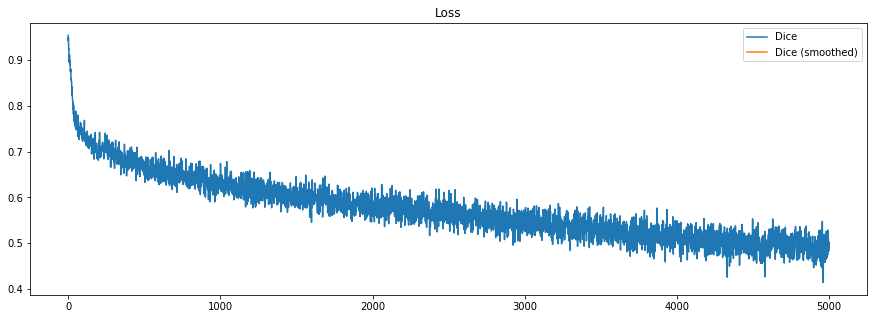

In [11]:
loss = np.load('loss.npy')

plt.figure(figsize=(15, 5))
plt.plot(loss, label='Dice')
plt.plot(pd.Series(train_pipeline.v('loss_history')).rolling(100).mean(), label='Dice (smoothed)')
plt.title('Loss')
plt.legend()
plt.show()

## Inference

To check the predictions, we will plot few examples for new cube

In [12]:
INFERENCE_BATCH_SIZE = 32

dataset = SeismicCubeset(FilesIndex(path=amplitudes_path('CUBE_24_VZC'), no_ext=True))
dataset.load(label_dir='/INPUTS/FAULTS/NPY_WIDTH_3/*', labels_class=Fault, transform=True, verify=True)
dataset.modify_sampler(dst='train_sampler', finish=True, low=0.0, high=1.0)

In [13]:
# Validation pipeline: no augmentations
val_template = (
    Pipeline()
#     .import_model('model', train_pipeline)
   .load_model('dynamic', EncoderDecoder, 'model', path='model.torch')
    # Load data/masks
    .crop(points=D('train_sampler')(INFERENCE_BATCH_SIZE), shape=CROP_SHAPE)
    .create_masks(dst='masks')
    .load_cubes(dst='images')
    .scale(mode='q', src='images')
    .predict_model('model',
                   B('images'),
                   fetches='sigmoid',
                   save_to=B('predictions'))
)

In [14]:
val_pipeline = val_template << dataset

In [15]:
%%time

batch = val_pipeline.next_batch(D('size'), n_epochs=None)
batch.predictions = batch.predictions > 0.5

CPU times: user 725 ms, sys: 420 ms, total: 1.15 s
Wall time: 1.14 s


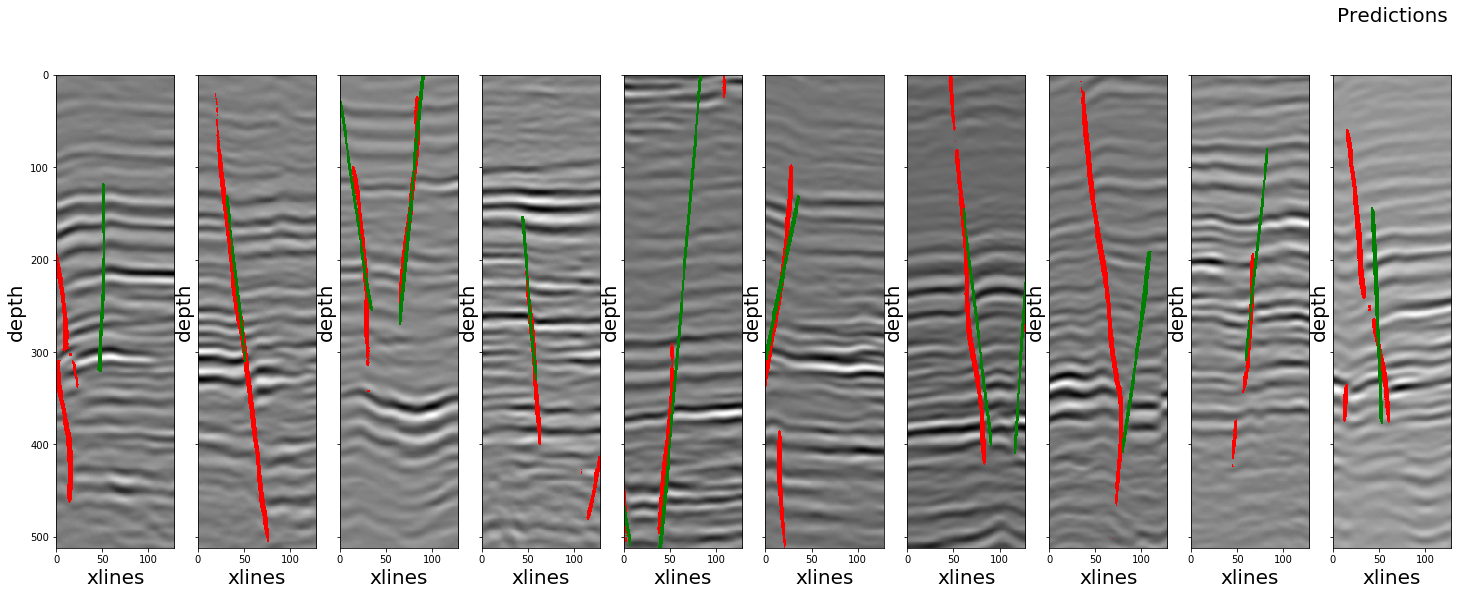

In [16]:
f, ax = plt.subplots(1, 10, sharey=True, figsize=(25, 140))
for b_idx in range(10):
    batch.plot_components('images', 'predictions', 'masks', slide=0, mode='overlap', idx=b_idx, alpha=[0.9, 0.5], title='Predictions', ax=ax[b_idx])